# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Variable Renewable Energy (VRE) assessment and forecast

### Project objectives
<div class="alert alert-block alert-info">

- Assess the onshore wind or solar photovoltaic hourly production over in metropolitan France regions using climate data and capacity factor observations.
- Predict the VRE power ahead of time.
</div>

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2021
- Climate variables of your choice from a global reanalysis with an hourly sampling from 2010 to 2019

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading all the data

In [68]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.model_selection import cross_val_score

<Axes: xlabel='time'>

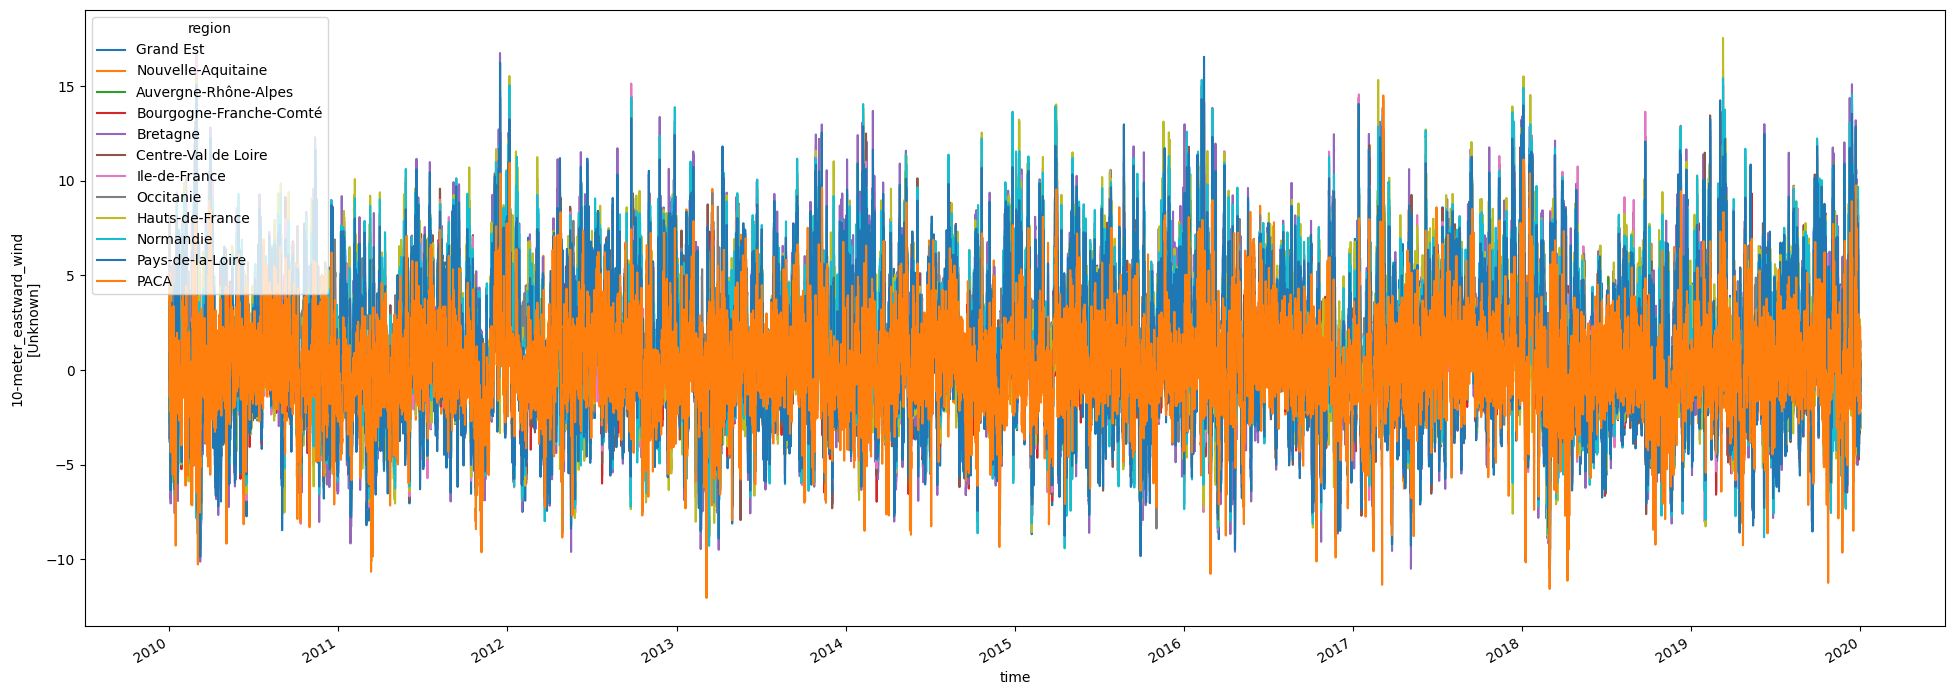

<Figure size 640x480 with 0 Axes>

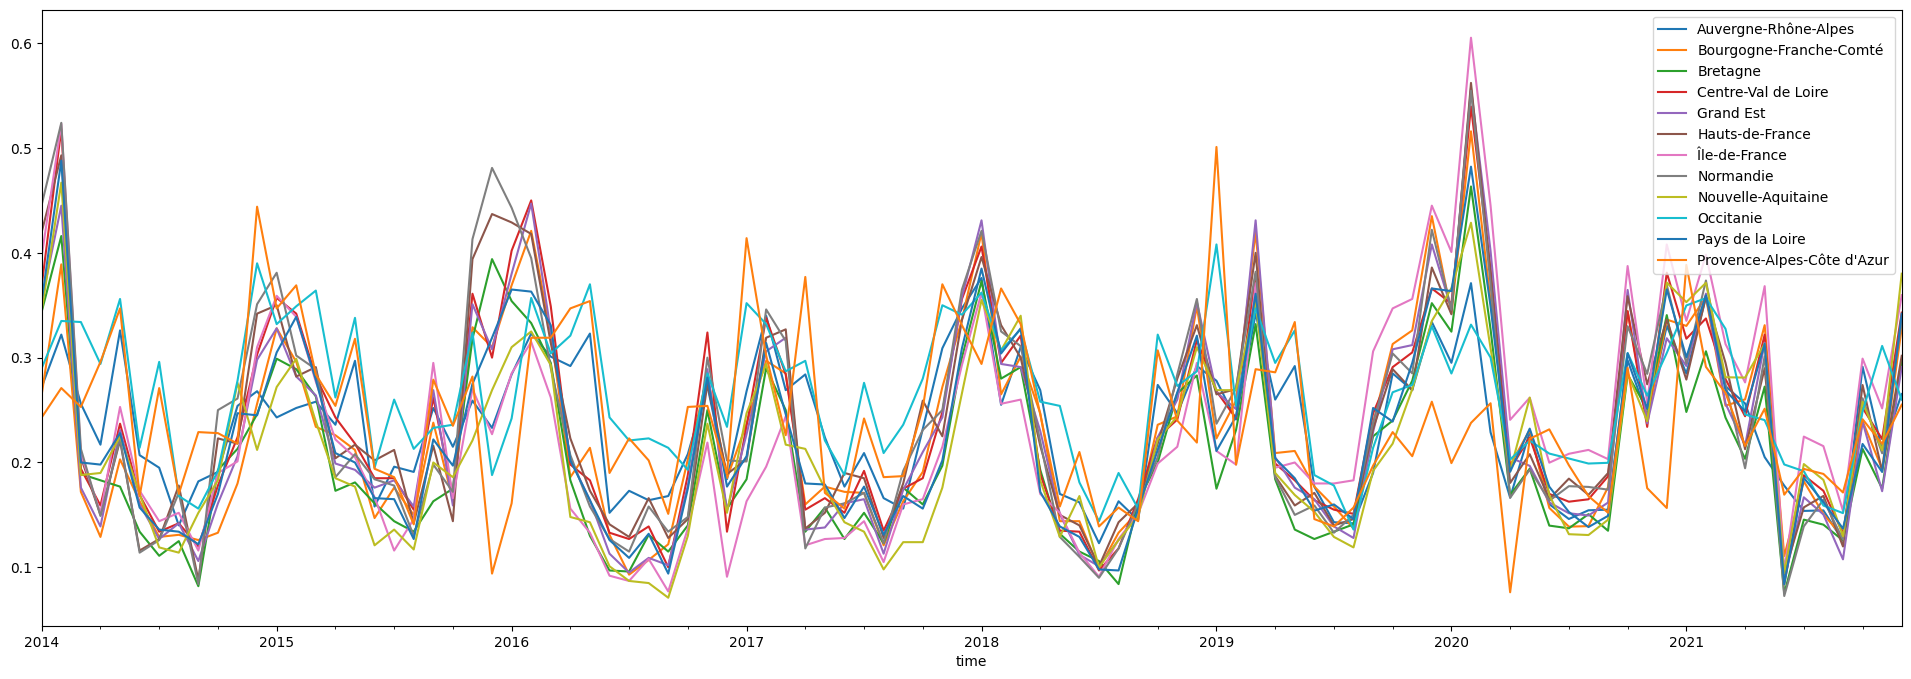

In [ ]:
# Directories where you saved the data
data_dir_energy = Path('data/projects/energy_france')
data_dir_climate = Path('data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)   
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
#plt.figure()
#plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure(figsize=(24,8))
da_climate_reg.plot.line(x='time')

# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot(figsize=(24,8))

### Selecting a location in metropolitan France and accessing climate variables of this location

In [2]:
ds_mask = xr.load_dataset(data_dir_climate / filename_mask)
da_mask = ds_mask['mask']

variables = [
    'zonal_wind',
    'meridional_wind',
    'surface_temperature',
    'surface_downward_radiation',
    'surface_density',
    'surface_specific_humidity',
    'upper_zonal_wind',
    'upper_meridional_wind',
    'height_500',
]

In [3]:
print("Avaiable regions in France: ")
da_climate_reg.region.values 

Avaiable regions in France: 


array(['Grand Est', 'Nouvelle-Aquitaine', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Ile-de-France', 'Occitanie', 'Hauts-de-France', 'Normandie',
       'Pays-de-la-Loire', 'PACA'], dtype=object)

#### Selecting a region

In [4]:
region_name = 'Ile-de-France'

In [5]:
dfs = []

for var in variables:
    ds_var = xr.load_dataset(data_dir_climate / filename_climate.format(var))
    da_var = ds_var[var]                               # (time, lat, lon)

    da_var_reg = da_var.groupby(da_mask).mean().rename(mask='region')
    da_var_reg['region'] = ds_mask['region'].values    # same as prof

    # select region, convert to pandas Series, rename with variable name
    series_region = da_var_reg.sel(region=region_name).to_pandas()
    dfs.append(series_region.rename(var))

# Combine all variables side by side
df_all_variables = pd.concat(dfs, axis=1)

#df_all_variables.head()

In [6]:
#df_energy['Île-de-France'].head()

#### Taking the monthly mean of the climate variables

In [7]:
df_climate_monthly = df_all_variables.resample('MS').mean()
df_climate_monthly

,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500
time,,,,,,,,,
2010-01-01,0.113088,-0.318379,272.273590,43.559608,1.277740,0.003301,0.350395,-0.394260,5431.350586
2010-02-01,1.520094,1.633788,275.193329,71.057159,1.250808,0.004014,2.226946,2.338912,5351.853027
2010-03-01,0.139313,0.279691,278.706116,141.006073,1.250952,0.004432,0.289097,0.467306,5505.052246
2010-04-01,-0.329032,-0.835640,283.016418,226.640015,1.233363,0.005089,-0.499806,-1.213971,5592.165039
2010-05-01,0.289953,-2.414946,284.744049,260.374359,1.221154,0.006000,0.313585,-3.403135,5595.019531
...,...,...,...,...,...,...,...,...,...
2019-08-01,1.408895,0.461117,293.096375,228.612228,1.186036,0.008507,1.932217,0.466144,5764.394531
2019-09-01,1.105618,-0.042446,289.145721,190.179108,1.206204,0.007319,1.497324,-0.181627,5749.764648
2019-10-01,1.522698,1.881359,285.335632,93.818886,1.215386,0.007387,2.270087,2.770181,5654.728027


#### Overlaping data of CP and climate variables

In [8]:
df_climate_overlap = df_climate_monthly.loc['2014-01-01':'2019-12-01']
cf_overlap = df_energy['Île-de-France'].loc['2014-01-01':'2019-12-01']
cf_overlap = cf_overlap.rename('capacity_factor')
df_climate_overlap


,zonal_wind,meridional_wind,surface_temperature,surface_downward_radiation,surface_density,surface_specific_humidity,upper_zonal_wind,upper_meridional_wind,height_500
time,,,,,,,,,
2014-01-01,1.457212,3.932577,278.326843,35.078514,1.239541,0.005184,2.201479,5.413025,5441.876465
2014-02-01,2.368809,4.987933,278.731354,66.375504,1.236099,0.004937,3.462634,6.872248,5407.690918
2014-03-01,0.433149,0.747019,281.533936,150.002029,1.237386,0.004942,0.462770,1.120855,5576.235352
2014-04-01,0.240969,0.179756,284.320435,203.017075,1.222223,0.006059,0.329754,0.195392,5591.039062
2014-05-01,1.160403,0.544363,285.875427,242.731064,1.216665,0.006797,1.622033,0.683228,5610.685547
...,...,...,...,...,...,...,...,...,...
2019-08-01,1.408895,0.461117,293.096375,228.612228,1.186036,0.008507,1.932217,0.466144,5764.394531
2019-09-01,1.105618,-0.042446,289.145721,190.179108,1.206204,0.007319,1.497324,-0.181627,5749.764648
2019-10-01,1.522698,1.881359,285.335632,93.818886,1.215386,0.007387,2.270087,2.770181,5654.728027


In [9]:
cf_overlap

time
2014-01-01    0.397
2014-02-01    0.523
2014-03-01    0.208
2014-04-01    0.152
2014-05-01    0.253
              ...  
2019-08-01    0.183
2019-09-01    0.306
2019-10-01    0.347
2019-11-01    0.356
2019-12-01    0.445
Name: capacity_factor, Length: 72, dtype: float64

In [10]:
df_dataset = df_climate_overlap.copy()
df_dataset['capacity_factor'] = cf_overlap
df_dataset = df_climate_overlap.join(cf_overlap, how='inner')
#df_dataset.head()

#### Evaluating linear correlation between the climate variables and CP value

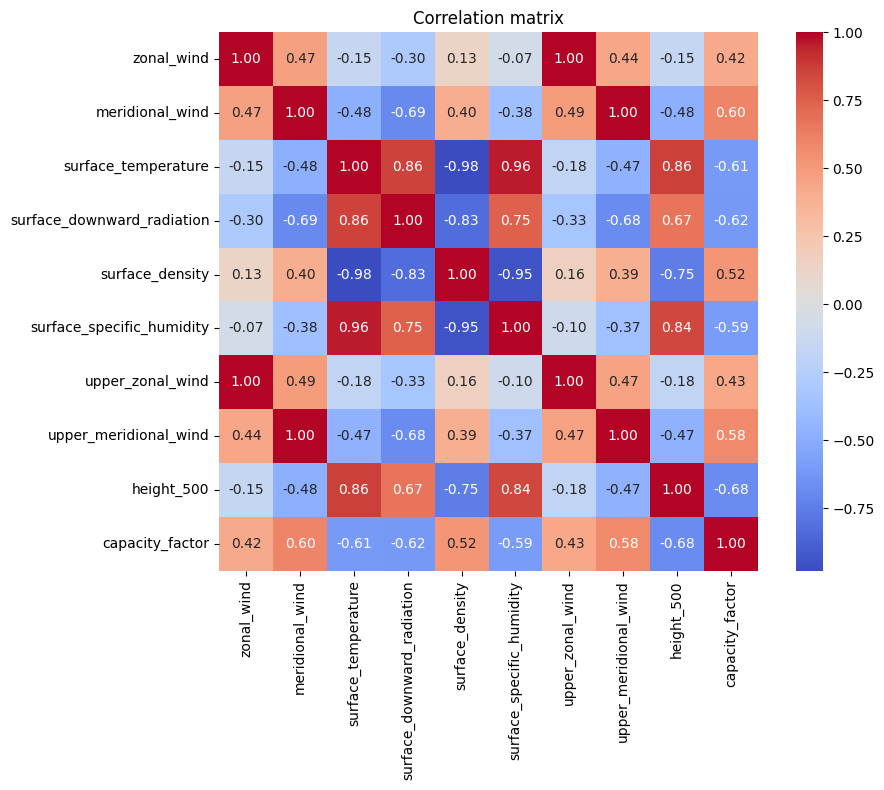

In [13]:
corr = df_dataset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


According to the last column values we can see that the lesser linearly correlated variable has a value of 0.42 which does not indicate a very weak correlation. 

#### Data viewing

#### All time - CP

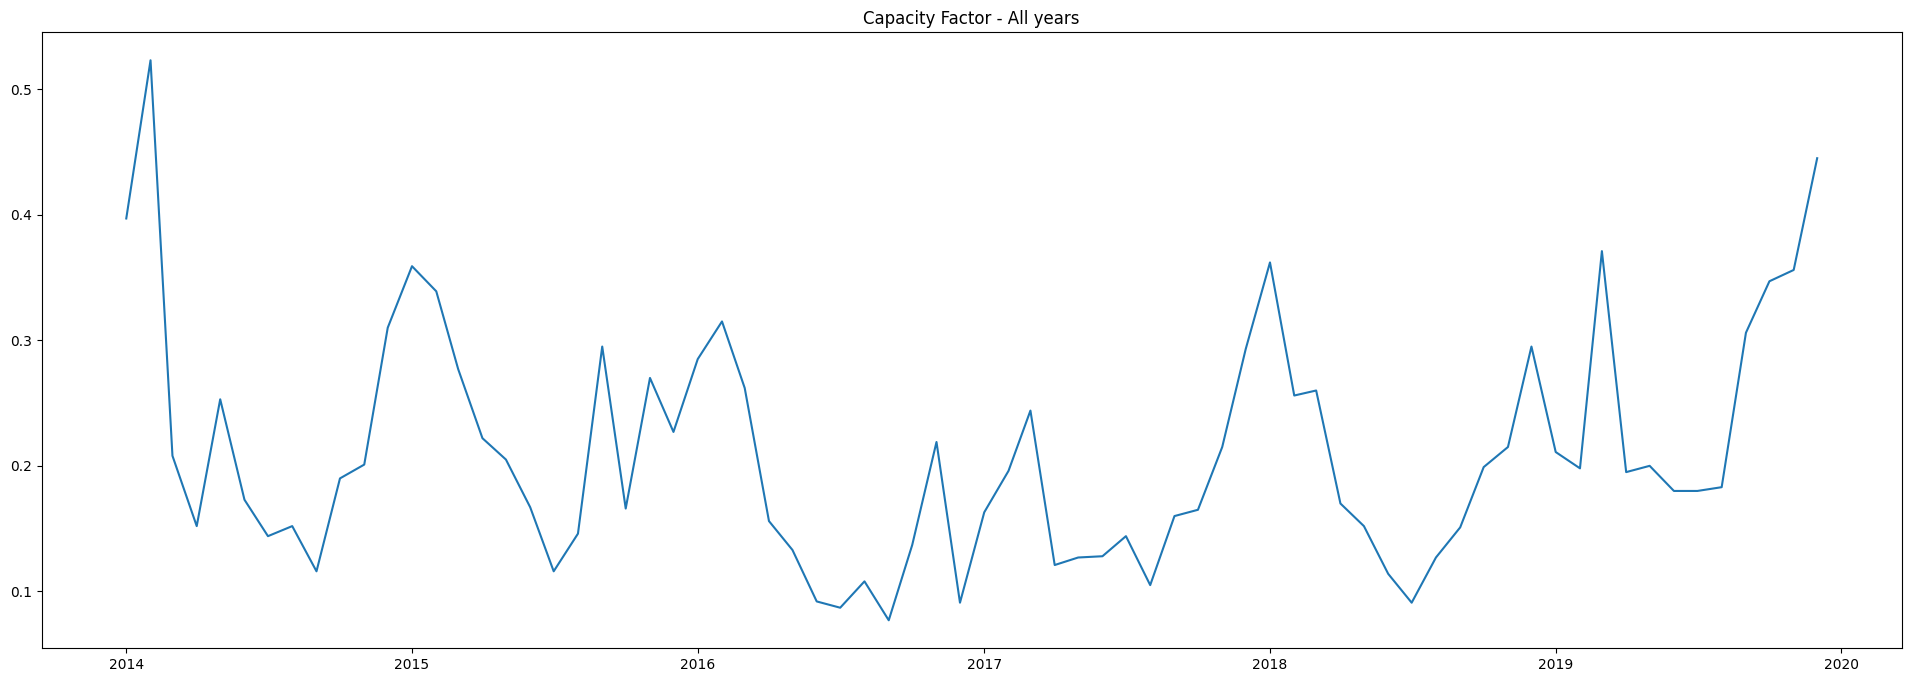

In [14]:
plt.figure(figsize=(24,8))
plt.plot(cf_overlap)
plt.title("Capacity Factor - All years")
plt.show()

a seasonality is well expected and can be identified, where the cp increase on the winters and decrease at the summers.

#### Years superposed

#### CP

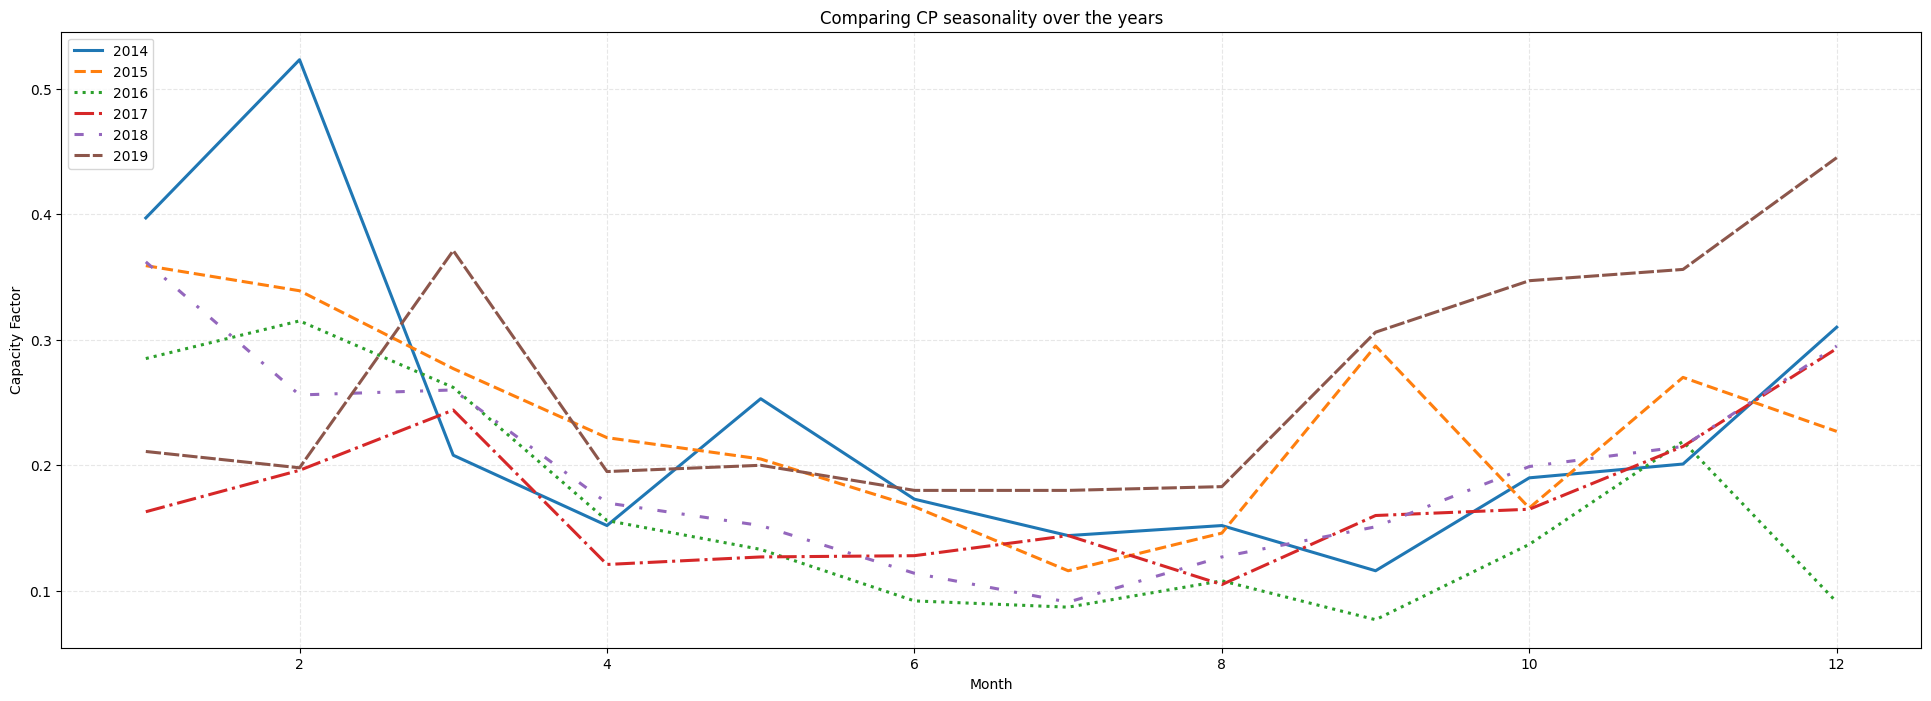

In [15]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',       
    '--',      
    ':',     
    '-.',     
    (0, (3, 5, 1, 5)), 
    (0, (5, 1))         
]

years = cf_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = cf_overlap[str(year)]
    ls = line_styles[i % len(line_styles)]   # repete padrões se tiver mais de 6 anos
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Capacity Factor")
plt.title("Comparing CP seasonality over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


#### Some climate variables

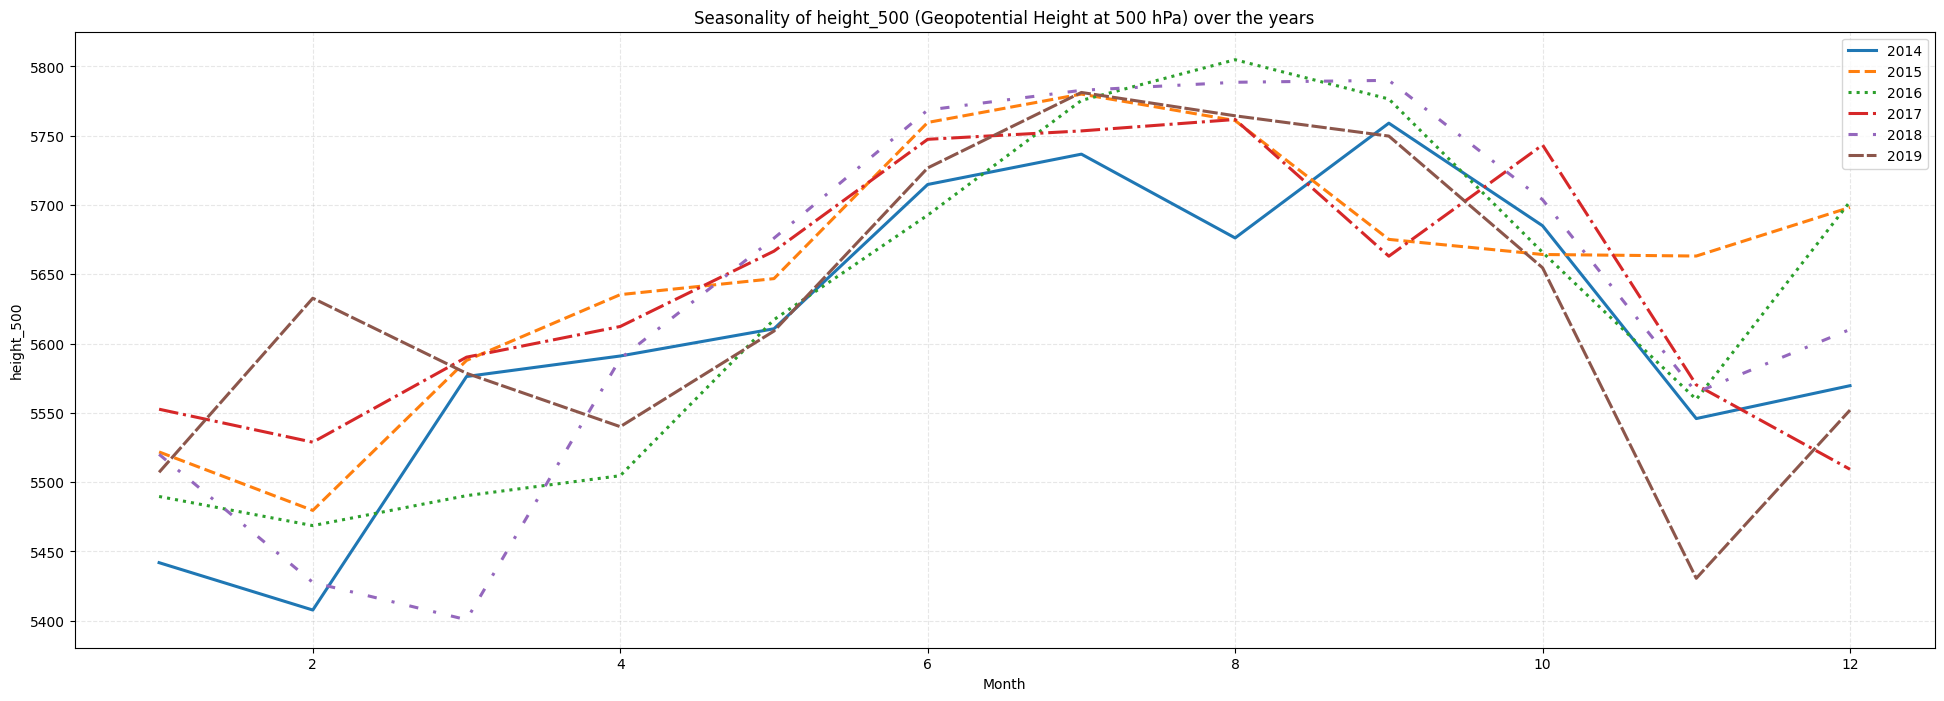

In [16]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]


years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['height_500'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("height_500")
plt.title("Seasonality of height_500 (Geopotential Height at 500 hPa) over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


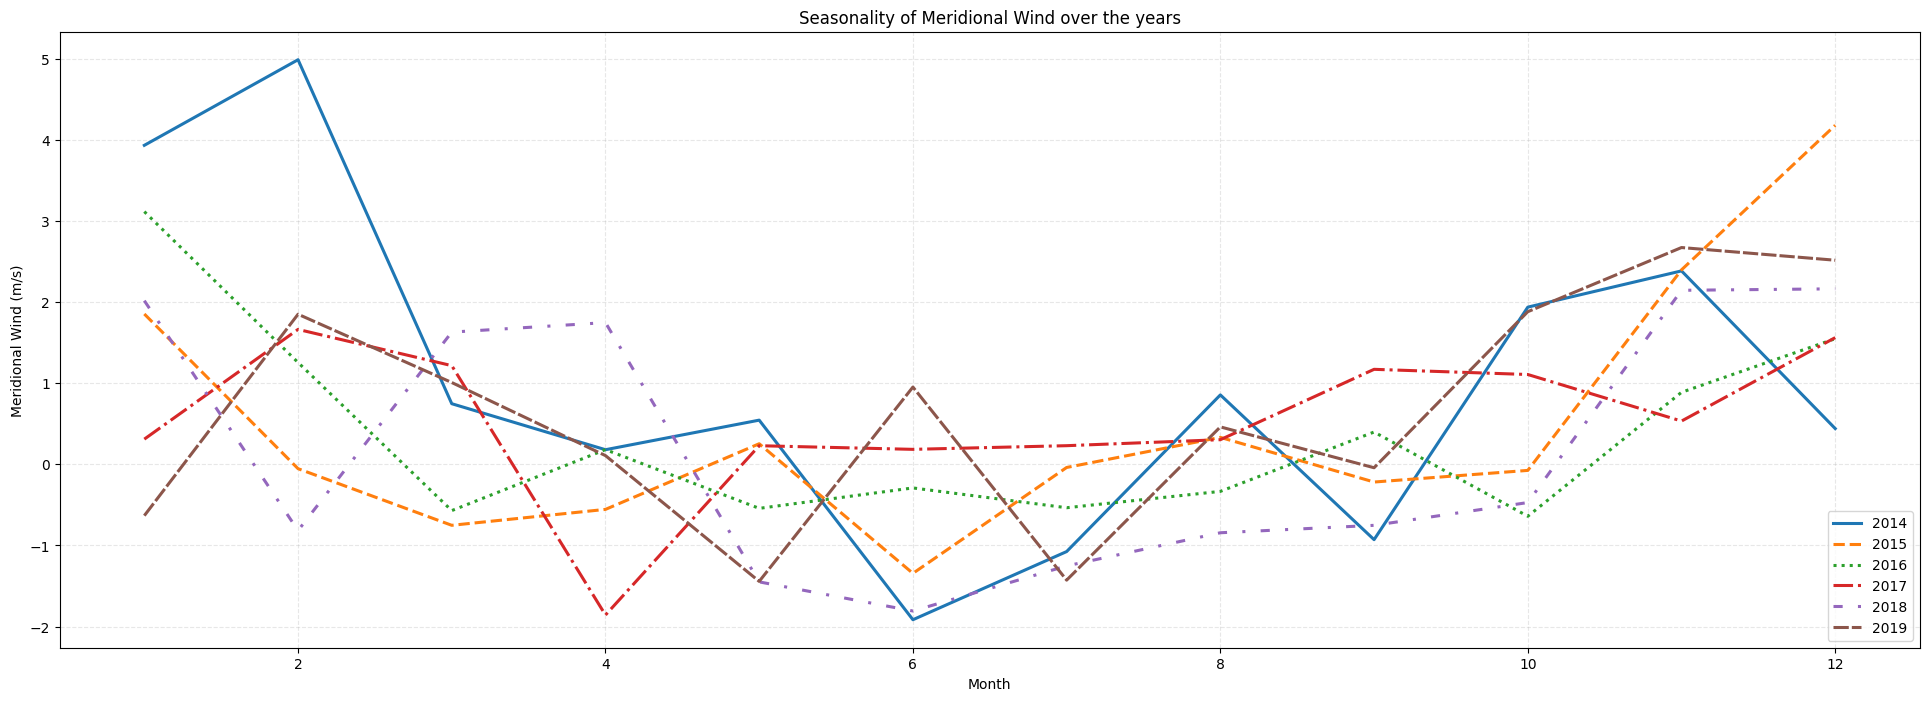

In [19]:
plt.figure(figsize=(24,8))

line_styles = [
    '-',          
    '--',         
    ':',          
    '-.',         
    (0, (3, 5, 1, 5)),  
    (0, (5, 1))         
]

years = df_climate_overlap.index.year.unique()

for i, year in enumerate(years):
    serie = df_climate_overlap['meridional_wind'].loc[str(year)]
    ls = line_styles[i % len(line_styles)]
    
    plt.plot(
        serie.index.month,
        serie.values,
        label=str(year),
        linestyle=ls,
        linewidth=2.2
    )

plt.legend()
plt.xlabel("Month")
plt.ylabel("Meridional Wind (m/s)")
plt.title("Seasonality of Meridional Wind over the years")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## 1. Linear Regression

We consider a linear regression model of the form:

$$
\hat{y} = X\beta + b
$$

where:

* **(X)** is the matrix of input features
* **(y)** is the target vector
* **$\hat{y}$** is the model prediction
* **$\beta$** is the vector of **model coefficients**, representing the contribution of each feature
* **(b)** is the intercept term

## **2. Loss Functions for Each Model**

### **2.1 Ordinary Least Squares (OLS)**

OLS minimizes the **sum of squared errors**:

$$
\min_{\beta} ; |y - X\beta|_2^2
$$

This corresponds to finding the coefficients that best fit the data.

## Linear regression

#### Testing more recent data performance when training the linear regression model

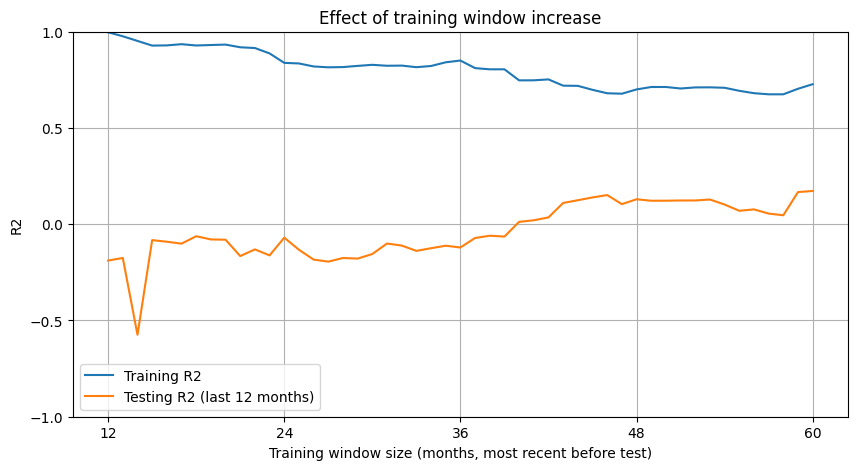

In [50]:
df = df_dataset.copy()       
df = df.sort_index()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values

n_samples = len(df)
test_size = 12                    # últimos 2 meses como teste
test_start = n_samples - test_size 

n_train_max = test_start         

R2_train = np.zeros(n_train_max + 1)
R2_test  = np.zeros(n_train_max + 1)

for i in range(12, n_train_max + 1):

    train_start = test_start - i
    train_end   = test_start

    X_train_raw = X_full[train_start:train_end, :]
    y_train = y_full[train_start:train_end]

    X_test_raw  = X_full[test_start:, :]
    y_test = y_full[test_start:]

    mean = X_train_raw.mean(axis=0)
    std  = X_train_raw.std(axis=0)

    #std[std == 0] = 1e-8

    X_train = (X_train_raw - mean) / std
    X_test  = (X_test_raw  - mean) / std

    model = LinearRegression().fit(X_train, y_train)

    R2_train[i] = model.score(X_train, y_train)
    R2_test[i]  = model.score(X_test, y_test)


train_sizes = np.arange(12, n_train_max + 1)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, R2_train[12:], label='Training R2')
plt.plot(train_sizes, R2_test[12:], label='Testing R2 (last 12 months)')
plt.xlabel('Training window size (months, most recent before test)')
plt.ylabel('R2')
plt.xticks([12, 24, 36, 48, 60])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.ylim(-1, 1)
plt.title('Effect of training window increase')
plt.legend()
plt.grid()
plt.show()

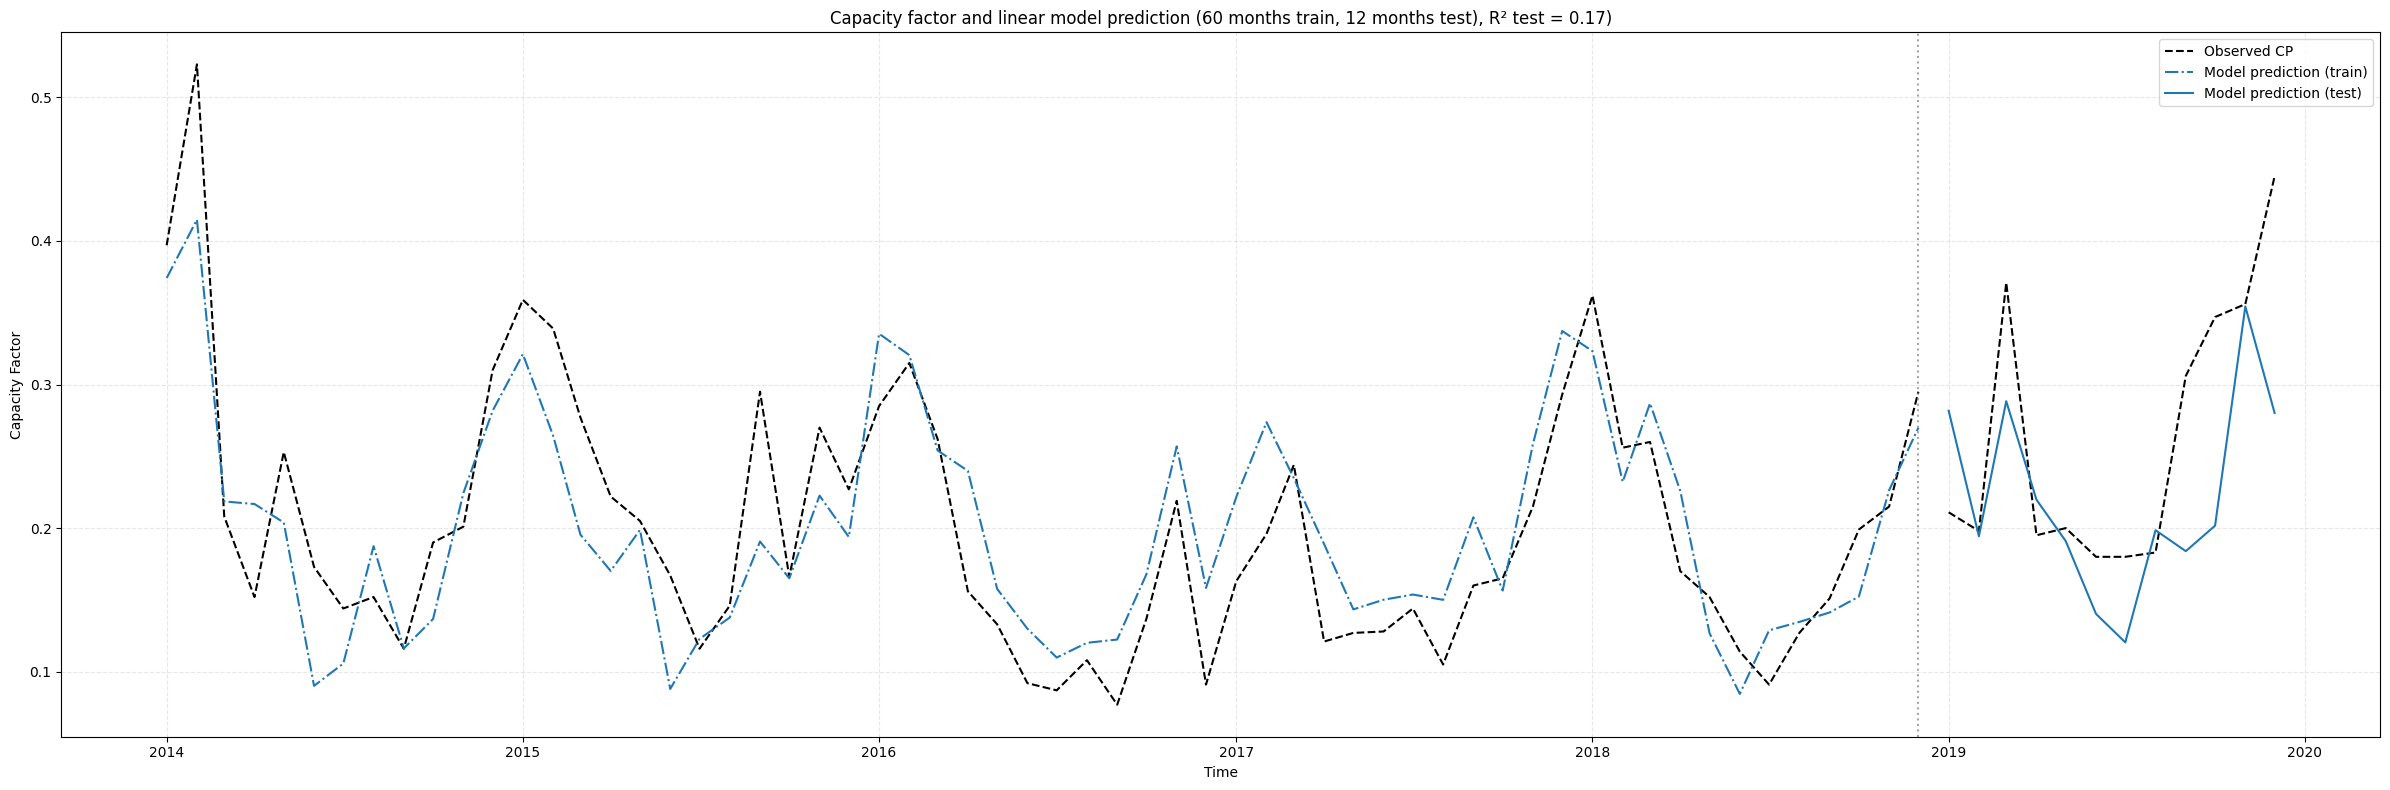

In [ ]:
df = df_dataset.sort_index().copy()

X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

n_train = 60
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std


model = LinearRegression().fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)
plt.figure(figsize=(24,8))

plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)

plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)


plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)


plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)


plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)


R2_test = model.score(X_test, y_test)
plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and linear model prediction (60 months train, 12 months test), R² test = {R2_test:.2f})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Training without zonal winds

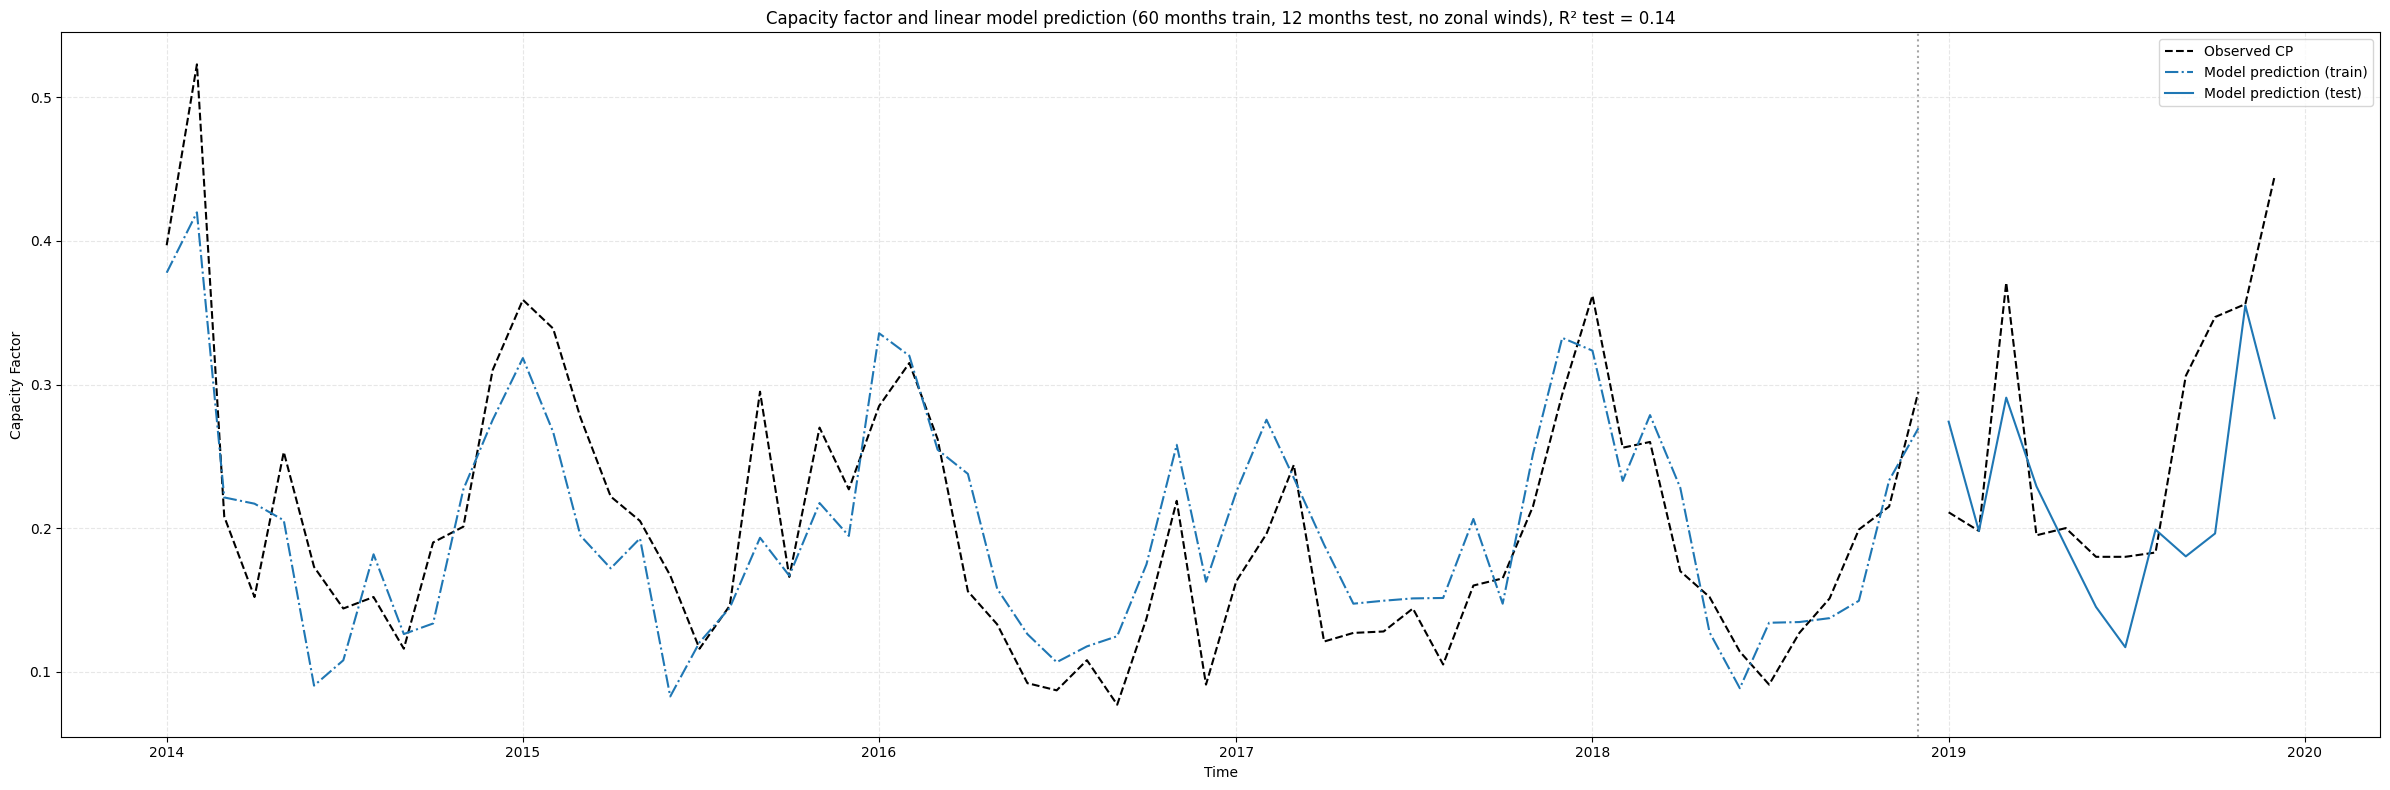

In [53]:
df = df_dataset.sort_index().copy()

# exclui capacity_factor, zonal_wind e upper_zonal_wind das features
X_full = df.drop(columns=["capacity_factor", "zonal_wind", "upper_zonal_wind"]).values
y_full = df["capacity_factor"].values
time_index = df.index

n_train = 60
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# regressão linear
model = LinearRegression().fit(X_train, y_train)

# predições
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# plot
plt.figure(figsize=(24,8))

# CP observado (treino + teste) em preto tracejado
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)
plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)

# predição no treino (traço-ponto azul)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)

# predição no teste (linha contínua azul)
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)

# linha vertical marcando fronteira treino/teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

R2_test = model.score(X_test, y_test)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and linear model prediction (60 months train, 12 months test, no zonal winds), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Training with the last 4 years instead of 5 years

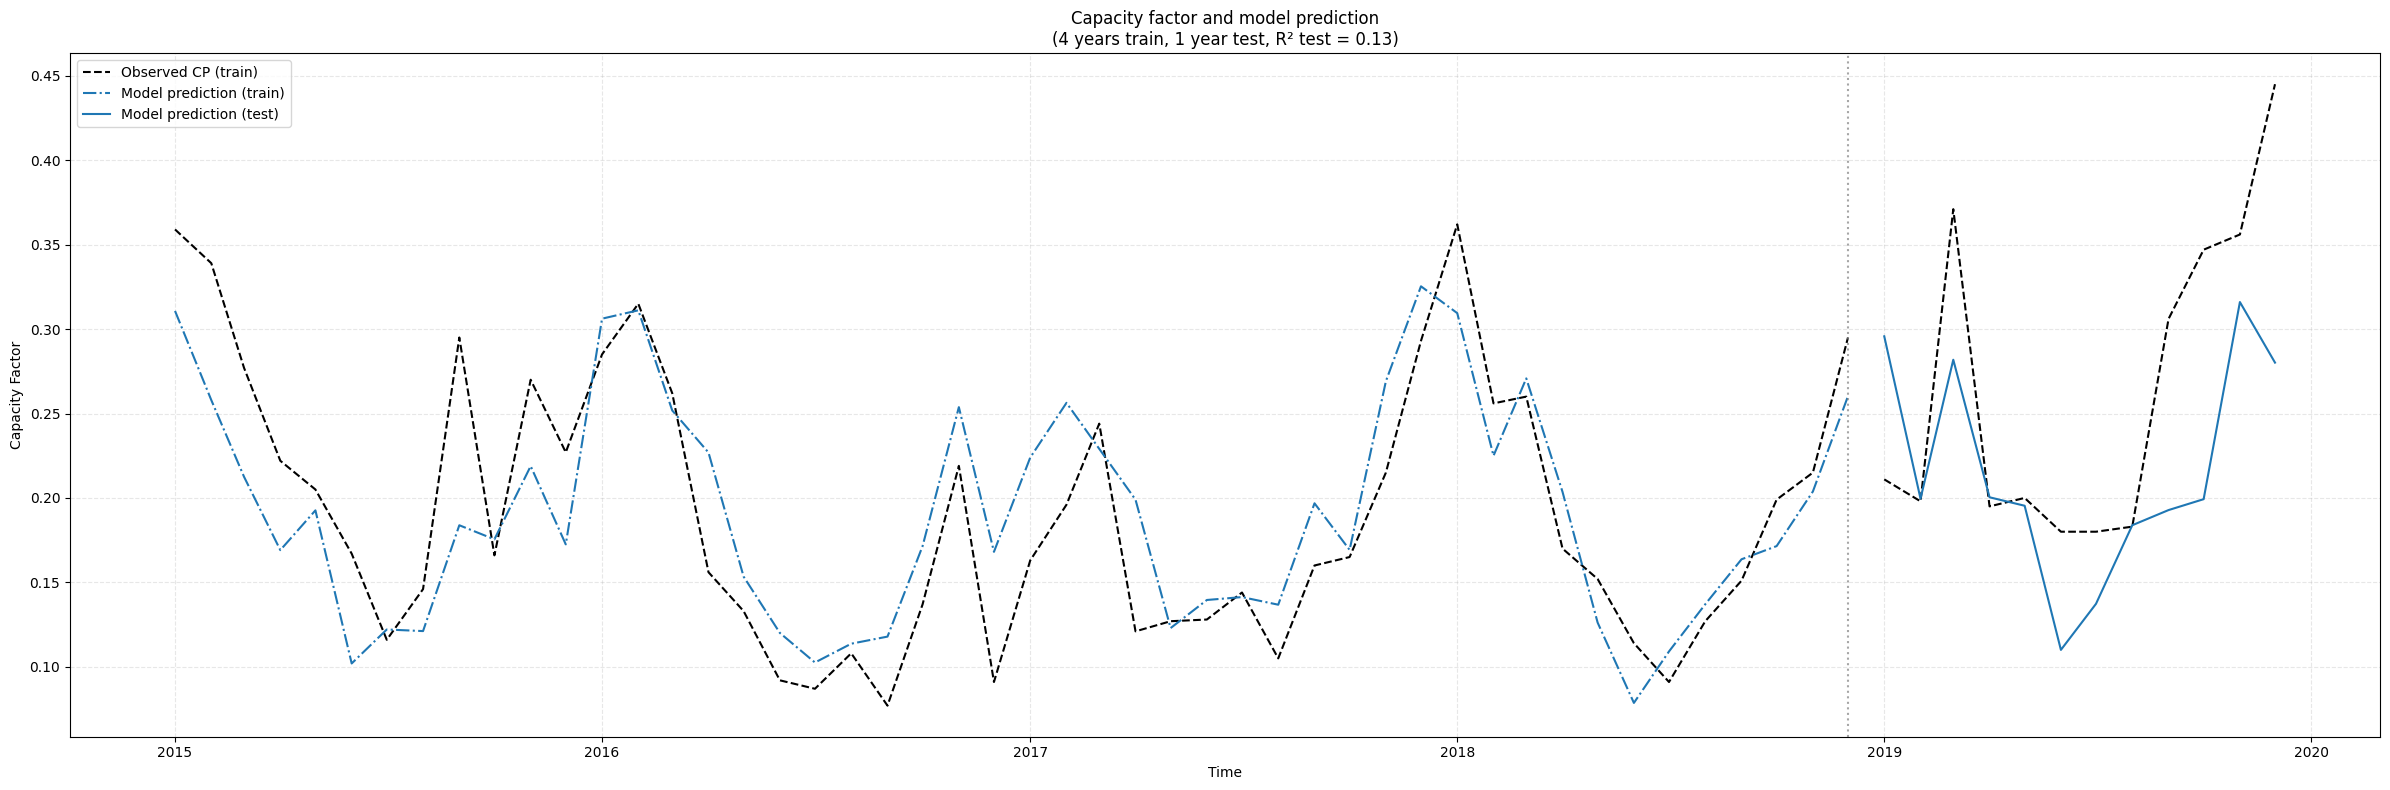

In [52]:
df_sub = df_dataset.sort_index().loc['2015-01-01':].copy()

X_full = df_sub.drop(columns=["capacity_factor"]).values
y_full = df_sub["capacity_factor"].values
time_index = df_sub.index

# 2) 4 anos de treino, 1 de teste (total = 5 anos = 60 meses)
n_months_per_year = 12
n_test  = 1 * n_months_per_year              # 1 ano de teste = 12 meses
n_train = len(df_sub) - n_test               # resto é treino (60 - 12 = 48 meses = 4 anos)

X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:n_train + n_test, :]
y_test = y_full[n_train:n_train + n_test]

# 3) Normalização com estatísticas APENAS do treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8  # evita divisão por zero

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# 4) Regressão linear
model = LinearRegression().fit(X_train, y_train)

# 5) Predições
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

# 6) Plot
plt.figure(figsize=(24,8))

# CP observado no treino
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP (train)'
)

plt.plot(
    time_index[n_train:],
    y_test,
    'k--',
)

# Predição do modelo no treino (azul traço-ponto)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Model prediction (train)'
)

# Predição do modelo no teste (azul contínuo)
plt.plot(
    time_index[n_train:n_train + n_test],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Model prediction (test)'
)

# Linha vertical separando treino e teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

R2_test = model.score(X_test, y_test)
plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and model prediction\n(4 years train, 1 year test, R² test = {R2_test:.2f})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Ridge Regression


### **2.2 Ridge Regression (L2 Regularization)**

Ridge adds a penalty proportional to the **L2 norm** of the coefficients:

$$
\min_{\beta} ; \left( |y - X\beta|_2^2 + \alpha |\beta|_2^2 \right)
$$

where:

* $|\beta|_2 = \left( \sum_j \beta_j^2 \right)^{1/2}$
* $\alpha > 0$ is the regularization strength

The L2 penalty shrinks all coefficients toward zero but **never forces any of them to become exactly zero**.



### **2.3 Lasso Regression (L1 Regularization)**

Lasso adds a penalty proportional to the **L1 norm** of the coefficients:

$$
\min_{\beta} ; \left( |y - X\beta|_2^2 + \alpha |\beta|_1 \right)
$$

where:

* $|\beta|_1 = \sum_j |\beta_j|$

The L1 penalty encourages sparsity, meaning that **Lasso can force some coefficients to become exactly zero**, effectively performing feature selection.



## **3. Why the Norm Type and α Change Feature Importance**

### **Effect of the Regularization Term**

$
\text{Loss} = \underbrace{|y - X\beta|*2^2}*{\text{fit to data}} + \underbrace{\alpha \cdot R(\beta)}_{\text{regularization}}
$

where:

* $R(\beta)$ is either the L1 or L2 norm
* **α controls how much the regularization term influences the optimization**


### **How the Norms Affect β**

#### **L2 norm (Ridge)**

* Penalizes **large values** of $\beta_j$
* Encourages coefficients to be **small but not zero**
* Reduces variance and stabilizes the model under multicollinearity
* Keeps all features in the model but decreases their influence

#### **L1 norm (Lasso)**

* Penalizes the **absolute value** of coefficients
* Has a geometric shape with **sharp corners** at zero
* These corners encourage coefficients to become **exactly zero**
* Performs automatic **feature selection**

---

### **Role of α**

α scales the strength of the penalty:

* If **α = 0**, Ridge and Lasso reduce to ordinary least squares
* If **α increases**:

  * Ridge shrinks coefficients smoothly
  * Lasso forces more coefficients to zero

Thus, **the choice of norm and the magnitude of α directly determine the final feature importance** by controlling how the model balances accuracy vs. coefficient size.


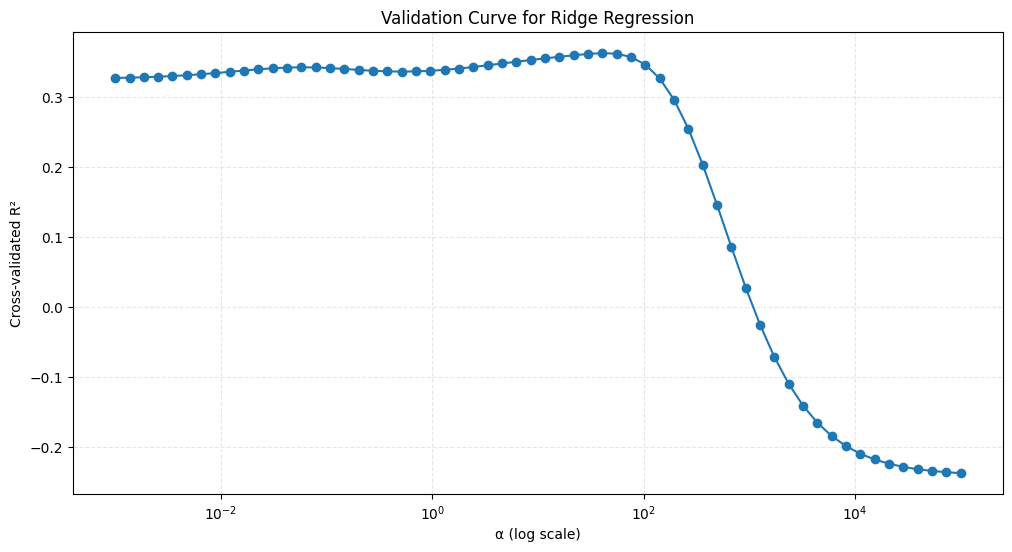

Best alpha found: 40.75392965871778
Best CV R²: 0.3633460863514698


In [77]:
alphas = np.logspace(-3, 5, 60)  # valores de alpha
r2_cv = []                       # guardar os R2 médios em CV
coefs = []                       # guardar coeficientes para análise posterior

# Cross-validation "padrão" (KFold) em cima do X_train, y_train
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    # 5-fold cross validation
    scores = cross_val_score(ridge, X_train, y_train, cv=5)
    r2_cv.append(scores.mean())
    
    # ajusta no treino completo (60 meses) para guardar coeficientes
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

r2_cv = np.array(r2_cv)
coefs = np.array(coefs)

plt.figure(figsize=(12,6))
plt.plot(alphas, r2_cv, marker='o')
plt.xscale('log')
plt.xlabel("α (log scale)")
plt.ylabel("Cross-validated R²")
plt.title("Validation Curve for Ridge Regression")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# melhor alpha e melhor R2 em CV
best_idx = np.argmax(r2_cv)
best_alpha = alphas[best_idx]
best_r2 = r2_cv[best_idx]

print("Best alpha found:", best_alpha)
print("Best CV R²:", best_r2)


In [78]:
# OLS
ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
R2_ols = ols.score(X_test, y_test)

# Ridge com alpha ótimo
ridge_best = Ridge(alpha=best_alpha).fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)
R2_ridge = ridge_best.score(X_test, y_test)

R2_ols, R2_ridge


(0.17273644578899372, 0.0029875982620685138)

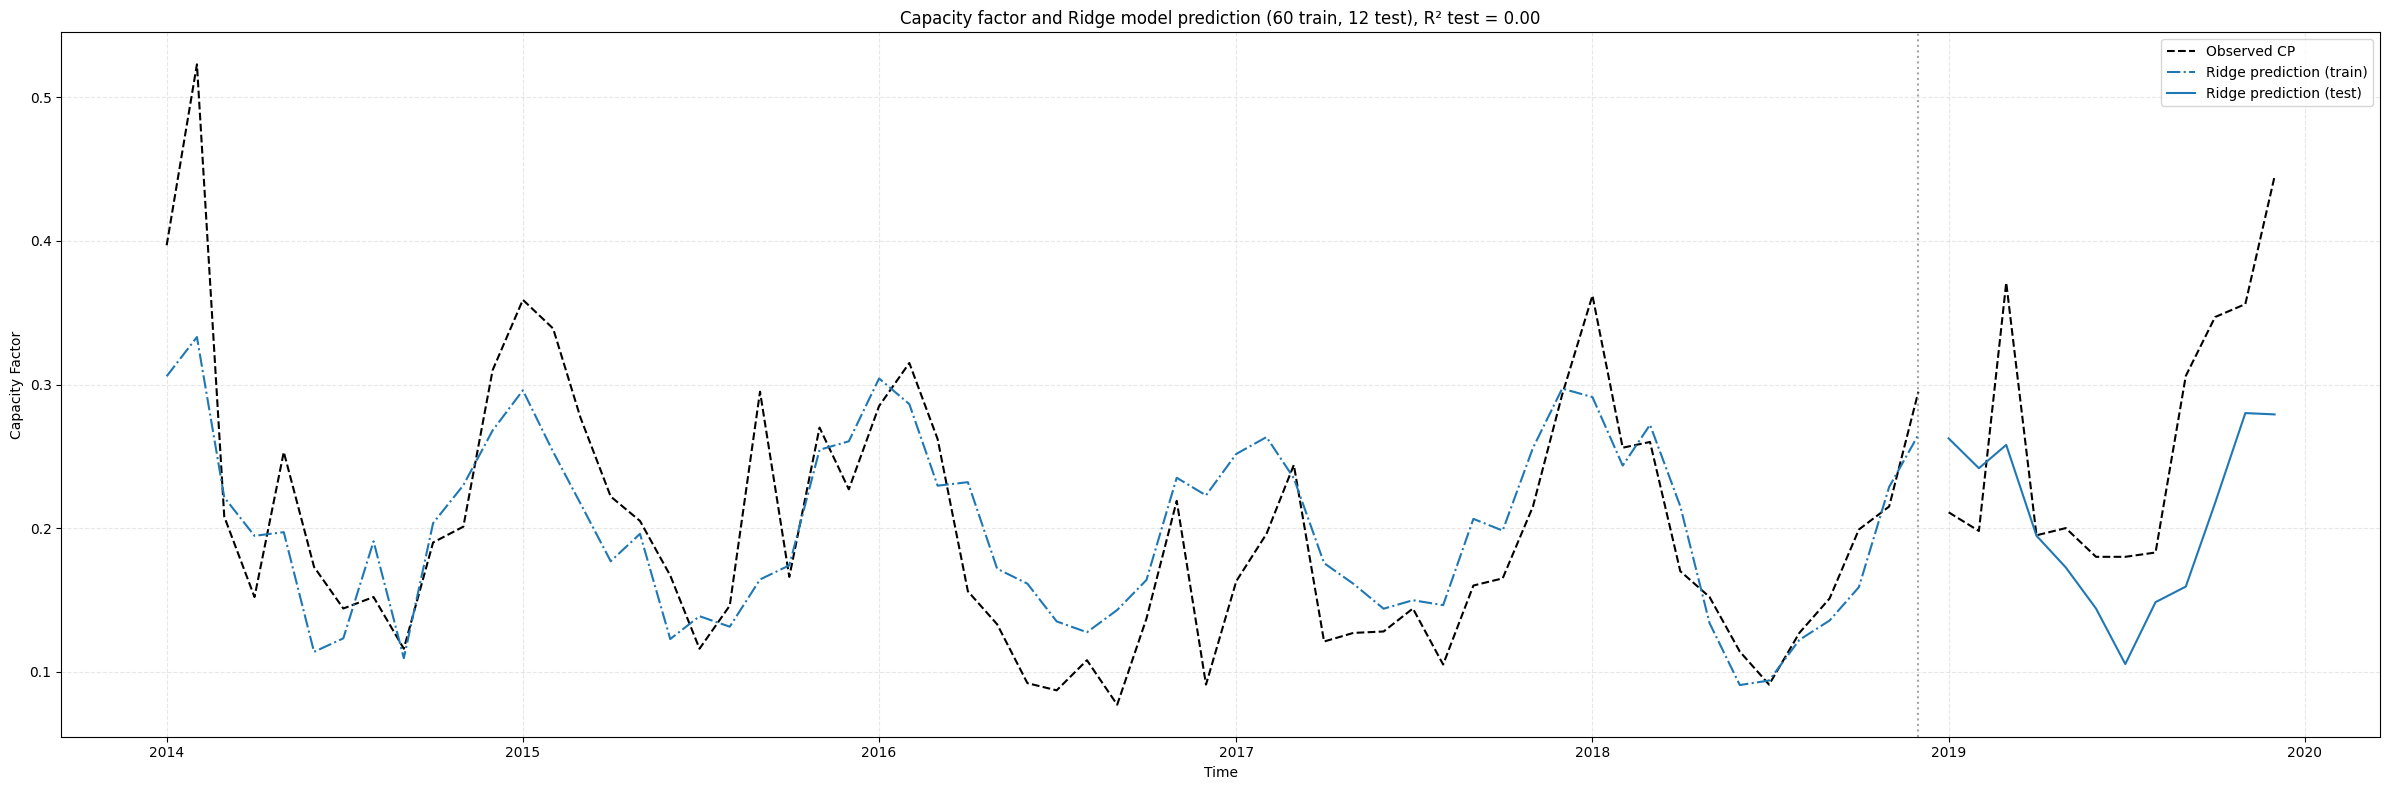

In [80]:
df = df_dataset.sort_index().copy()

# features: todas as climáticas, target: capacity_factor
X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# 60 meses de treino, resto (12) de teste
n_train = 60
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

X_test_raw  = X_full[n_train:, :]
y_test = y_full[n_train:]

# normalização só com o treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# modelo Ridge (alpha pode ser tunado depois via CV)
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)

# predições
y_pred_train = ridge.predict(X_train)
y_pred_test  = ridge.predict(X_test)

# R² no teste
R2_test = ridge.score(X_test, y_test)

# plot
plt.figure(figsize=(24,8))

# CP observado (treino + teste) em preto tracejado
plt.plot(
    time_index[:n_train],
    y_train,
    'k--',
    label='Observed CP'
)
plt.plot(
    time_index[n_train:],
    y_test,
    'k--'
)

# predição no treino (traço-ponto azul)
plt.plot(
    time_index[:n_train],
    y_pred_train,
    color='C0',
    linestyle='-.',
    label='Ridge prediction (train)'
)

# predição no teste (linha contínua azul)
plt.plot(
    time_index[n_train:],
    y_pred_test,
    color='C0',
    linestyle='-',
    label='Ridge prediction (test)'
)

# linha vertical separando treino e teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Capacity factor and Ridge model prediction (60 train, 12 test), R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


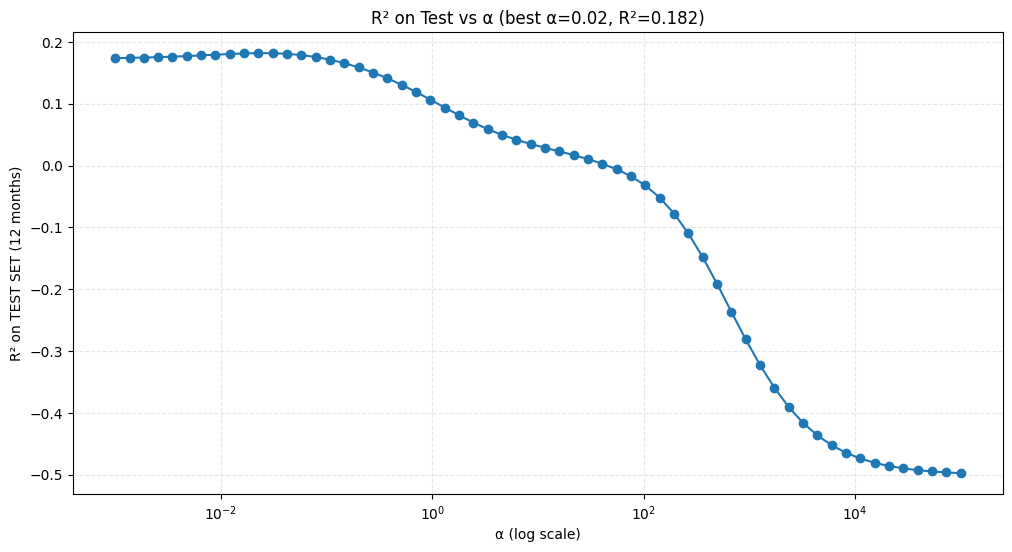

Best alpha according to TEST SET: 0.022695105366946685
Best R² on TEST SET: 0.18194437957624265


In [81]:
alphas = np.logspace(-3, 5, 60)  # valores de alpha
r2_test_list = []                # guardar R² no teste para cada alpha

for alpha in alphas:
    
    # treina um modelo Ridge para cada alpha
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # R² na janela de teste final (12 meses)
    r2_test = ridge.score(X_test, y_test)
    r2_test_list.append(r2_test)

r2_test_list = np.array(r2_test_list)

# encontrar melhor alpha segundo o TESTE REAL
best_alpha_test = alphas[np.argmax(r2_test_list)]
best_r2_test = r2_test_list[np.argmax(r2_test_list)]

# plot
plt.figure(figsize=(12,6))
plt.plot(alphas, r2_test_list, marker='o')
plt.xscale('log')
plt.xlabel("α (log scale)")
plt.ylabel("R² on TEST SET (12 months)")
plt.title(f"R² on Test vs α (best α={best_alpha_test:.2f}, R²={best_r2_test:.3f})")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("Best alpha according to TEST SET:", best_alpha_test)
print("Best R² on TEST SET:", best_r2_test)


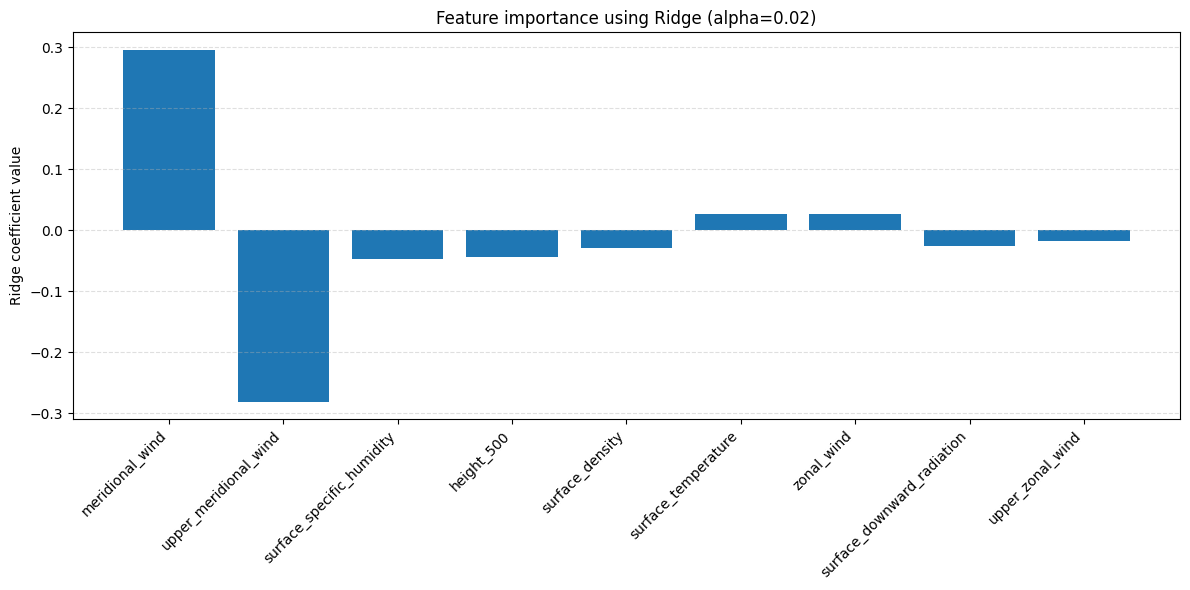

In [84]:
feature_names = df_dataset.drop(columns=["capacity_factor"]).columns

# treinar o modelo Ridge com alpha escolhido
ridge = Ridge(alpha=best_alpha_test)
ridge.fit(X_train, y_train)

# coeficientes (importância)
coefs = ridge.coef_

# ordenar por magnitude
idx_sorted = np.argsort(np.abs(coefs))[::-1]
coefs_sorted = coefs[idx_sorted]
features_sorted = feature_names[idx_sorted]

# plot
plt.figure(figsize=(12,6))
plt.bar(features_sorted, coefs_sorted)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Ridge coefficient value")
plt.title(f"Feature importance using Ridge (alpha={best_alpha_test:.2f})")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# imprimir coeficientes ordenados
#for f, c in zip(features_sorted, coefs_sorted):
#    print(f"{f:30s}  coef = {c:.4f}")


## Lasso regression

Best alpha (CV): 1.099e-02
Best CV R2: 0.385


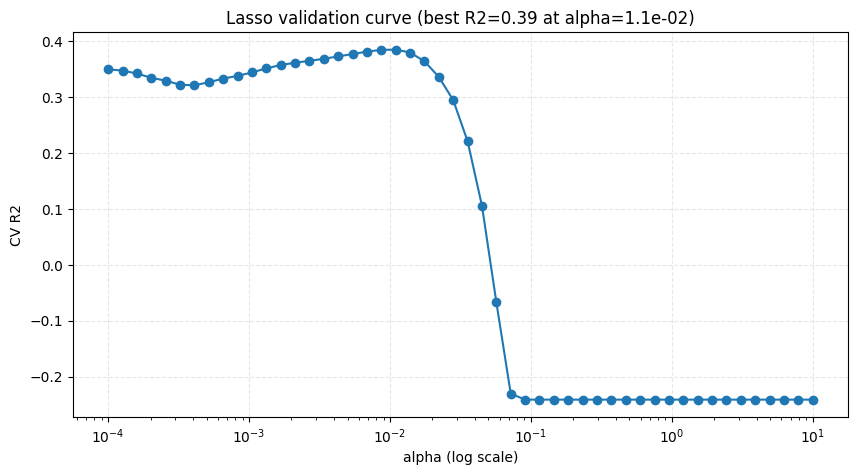

In [93]:
reg_class = Lasso
kwargs_lasso = dict(max_iter=10000)

alphas = np.logspace(-4, 1, 50)
r2_validation = np.empty(alphas.shape)
coefs = np.empty((len(alphas), X_train.shape[1]))

# aqui podemos usar, por exemplo, 5 folds (não ideal pra tempo, mas simples)
for k, alpha in enumerate(alphas):
    reg = reg_class(alpha=alpha, **kwargs_lasso)
    
    scores = cross_val_score(reg, X_train, y_train, cv=5)
    r2_validation[k] = scores.mean()
    
    reg.fit(X_train, y_train)
    coefs[k] = reg.coef_

i_best = np.argmax(r2_validation)
alpha_best = alphas[i_best]
r2_best = r2_validation[i_best]
coefs_best = coefs[i_best]

print(f"Best alpha (CV): {alpha_best:.3e}")
print(f"Best CV R2: {r2_best:.3f}")

# validation curve
plt.figure(figsize=(10,5))
plt.plot(alphas, r2_validation, marker='o')
plt.xscale('log')
plt.xlabel("alpha (log scale)")
plt.ylabel("CV R2")
plt.title(f"Lasso validation curve (best R2={r2_best:.2f} at alpha={alpha_best:.1e})")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

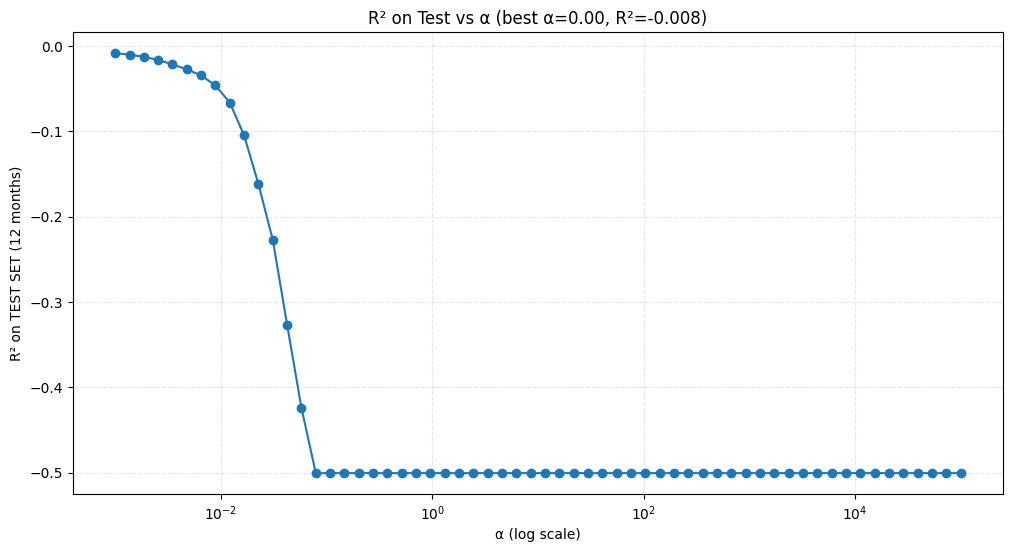

Best alpha according to TEST SET: 0.001
Best R² on TEST SET: -0.008140467369592619


In [ ]:
alphas = np.logspace(-3, 5, 60)
r2_test_list = []

for alpha in alphas:
    
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    r2_test = lasso.score(X_test, y_test)
    r2_test_list.append(r2_test)

r2_test_list = np.array(r2_test_list)

# melhor alpha segundo o teste real
best_idx = np.argmax(r2_test_list)
best_alpha_test = alphas[best_idx]
best_r2_test = r2_test_list[best_idx]

# gráfico
plt.figure(figsize=(12, 6))
plt.plot(alphas, r2_test_list, marker='o')
plt.xscale('log')
plt.xlabel("α (log scale)")
plt.ylabel("R² on TEST SET (12 months)")
plt.title(f"R² on Test vs α (best α={best_alpha_test:.2f}, R²={best_r2_test:.3f})")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("Best alpha according to TEST SET:", best_alpha_test)
print("Best R² on TEST SET:", best_r2_test)


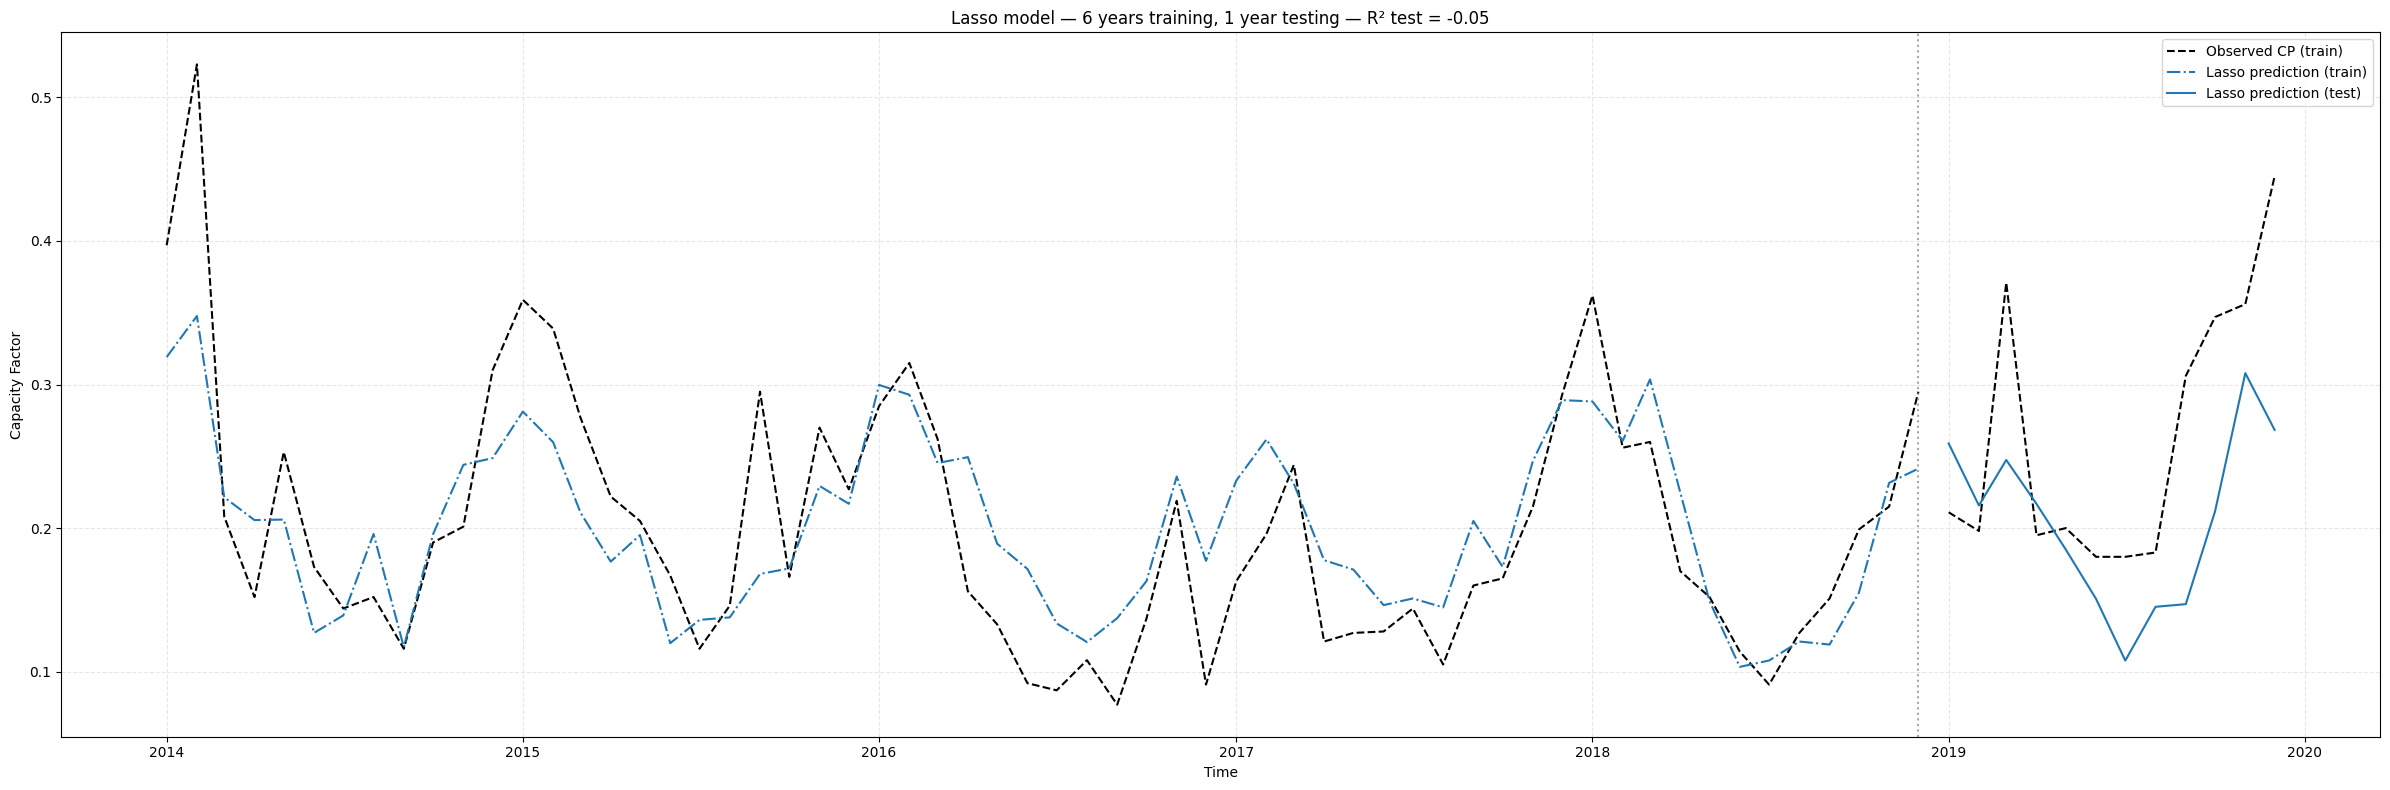

In [94]:
df = df_dataset.sort_index().copy()

# separar features e target
X_full = df.drop(columns=["capacity_factor"]).values
y_full = df["capacity_factor"].values
time_index = df.index

# 6 anos = 72 meses de treino
n_train = 60
X_train_raw = X_full[:n_train, :]
y_train = y_full[:n_train]

# teste = próximo ano (12 meses)
X_test_raw  = X_full[n_train:n_train+12, :]
y_test = y_full[n_train:n_train+12]

# normalização só com treino
mean = X_train_raw.mean(axis=0)
std  = X_train_raw.std(axis=0)
std[std == 0] = 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

# modelo Lasso (alpha ajustável)
lasso = Lasso(alpha=0.01, max_iter=100000)
lasso.fit(X_train, y_train)

# predições
y_pred_train = lasso.predict(X_train)
y_pred_test  = lasso.predict(X_test)

# R² no teste
R2_test = lasso.score(X_test, y_test)

# plot
plt.figure(figsize=(24,8))

# CP observado (treino + teste)
plt.plot(time_index[:n_train], y_train, 'k--', label='Observed CP (train)')
plt.plot(time_index[n_train:n_train+12], y_test, 'k--')

# predição do modelo no treino
plt.plot(time_index[:n_train], y_pred_train, color='C0', linestyle='-.',
         label='Lasso prediction (train)')

# predição do modelo no teste
plt.plot(time_index[n_train:n_train+12], y_pred_test, color='C0', linestyle='-',
         label='Lasso prediction (test)')

# linha vertical separando treino e teste
plt.axvline(time_index[n_train-1], color='gray', linestyle=':', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.title(f"Lasso model — 6 years training, 1 year testing — R² test = {R2_test:.2f}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

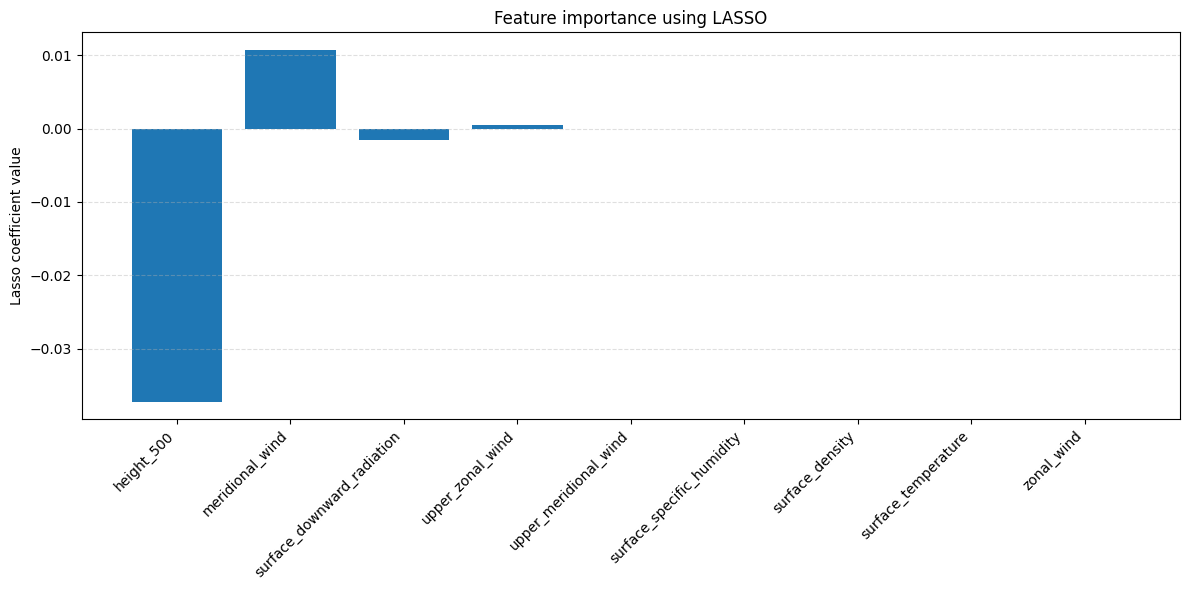

In [88]:
feature_names = df_dataset.drop(columns=["capacity_factor"]).columns

# treinar o modelo Lasso com alpha escolhido
lasso = Lasso(alpha=best_alpha_test, max_iter=100000)
lasso.fit(X_train, y_train)

# coeficientes
coefs = lasso.coef_

# ordenar por magnitude
idx_sorted = np.argsort(np.abs(coefs))[::-1]
coefs_sorted = coefs[idx_sorted]
features_sorted = feature_names[idx_sorted]

# plot
plt.figure(figsize=(12,6))
plt.bar(features_sorted, coefs_sorted)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Lasso coefficient value")
plt.title(f"Feature importance using LASSO")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# opcional: imprimir coeficientes ordenados
#for f, c in zip(features_sorted, coefs_sorted):
#    print(f"{f:30s}  coef = {c:.4f}")

#### Ridge and lasso method to analyse relation between the variables -> penalization methods, using all variables

#### Feature importance -> after model implemented -> which is the importance of each variable to the model

#### Neural networks

### After all: evaluate climate change in the energy prediction (we have energy demand and energy production - only pv or wind)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>